In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50 as an example for ViT alternative
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses INFO (1), WARNING (2), and ERROR (3)


2025-03-05 02:52:55.975830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-05 02:52:56.531522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the dataset
train_df = pd.read_csv('raf-db/train_labels.csv')
val_df = pd.read_csv('raf-db/test_labels.csv')
train_df = train_df.rename(columns={'image': 'pth', 'label': 'label'})
val_df = val_df.rename(columns={'image': 'pth', 'label': 'label'})

BASE_PATH = "DATASET/train/"
# Function to update paths
def update_path(row):
    return os.path.join(BASE_PATH, str(row['label']), row['pth'])

# Apply function to update the 'path' column
train_df['pth'] = train_df.apply(update_path, axis=1)

BASE_PATH = "DATASET/test/"
val_df['pth'] = val_df.apply(update_path, axis=1)

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))

# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Set the target image size (IMG_SIZE)
IMG_SIZE = 96

Training Dataset : label
4    4772
7    2524
5    1982
1    1290
3     717
6     705
2     281
Name: count, dtype: int64
Validation Dataset : label
4    1185
7     680
5     478
1     329
6     162
3     160
2      74
Name: count, dtype: int64


I0000 00:00:1741143178.446810 3636915 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741143178.606414 3637015 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [3]:
val_df.head()

,pth,label
0,DATASET/test/5/test_0001_aligned.jpg,5
1,DATASET/test/1/test_0002_aligned.jpg,1
2,DATASET/test/4/test_0003_aligned.jpg,4
3,DATASET/test/1/test_0004_aligned.jpg,1
4,DATASET/test/5/test_0005_aligned.jpg,5


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
lock = threading.Lock()
def detect_and_crop_face(image):
    """Detects and crops the face using BlazeFace (MediaPipe), then resizes to target size."""
    with lock:
        if image is None:
            print("Empty")
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with face detection
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
    
                # Calculate bounding box coordinates
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
    
                # Optionally expand the bounding box slightly
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
    
                # Crop the face from the image using the bounding box
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                
                # Resize the cropped face to the target size (IMG_SIZE x IMG_SIZE)
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))
    
        # If no face detected, return resized version of the original image
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))

W0000 00:00:1741143178.664575 3637006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [5]:
# Define emotion labels
emotion_labels = ['1', '2', '3', '4', '5', '6', '7']
num_classes = len(emotion_labels)  # 7 classes

def image_generator(dataframe, batch_size=32):
    while True:
        batch_images = []
        batch_labels = []
        
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle at start of epoch

        for i in range(len(dataframe)):
            row = dataframe.iloc[i]
            img_path = os.path.join('raf-db', row['pth'])  # Ensure path correctness
            image = cv2.imread(img_path)

            # Detect and crop the face
            face = detect_and_crop_face(image)
            if face is not None:
                batch_images.append(face)

                # Convert label from string to index
                label_str = str(row['label'])
                if label_str not in emotion_labels:
                    print(f"Warning: Unexpected label '{label_str}' found!")
                    continue  # Skip if label is not in predefined list

                label_index = emotion_labels.index(label_str)  # Convert "happy" -> 4

                # Fix: Ensure correct shape for one-hot encoding
                one_hot_label = to_categorical(label_index, num_classes=num_classes)

                batch_labels.append(one_hot_label)

            # Yield batch when full
            if len(batch_images) == batch_size:
                yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)
                batch_images = []
                batch_labels = []

        # Yield remaining images if any
        if len(batch_images) > 0:
            yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)


In [6]:
x_batch, y_batch = next(image_generator(train_df, batch_size=32))
print("Batch X shape:", x_batch.shape)  # Expected: (batch_size, 96, 96, 3)
print("Batch Y shape:", y_batch.shape)  # Expected: (batch_size, 8) for one-hot labels

Batch X shape: (32, 96, 96, 3)
Batch Y shape: (32, 7)


In [7]:
# Identity Normalization (Idn) Module with Batch Normalization
def create_identity_normalization():
    inputs = keras.Input(shape=(96, 96, 3))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return keras.Model(inputs, x, name="IdentityNormalization")

# Mixture of Experts (MoE) Module with Improved Gating
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor with Dropout
def create_cnn_feature_extractor():
    inputs = keras.Input(shape=(96, 96, 3))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor")

# Transformer Feature Extractor using ResNet50
def create_transformer_feature_extractor():
    inputs = keras.Input(shape=(96, 96, 3))
    base_model = ResNet50(input_shape=(96, 96, 3), include_top=False, weights="imagenet")(inputs)
    x = layers.GlobalAveragePooling2D()(base_model)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    return keras.Model(inputs, x, name="TransformerFeatureExtractor")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(96, 96, 3))
    
    idn_model = create_identity_normalization()
    cnn_model = create_cnn_feature_extractor()
    transformer_model = create_transformer_feature_extractor()
    
    identity_features = idn_model(inputs)
    cnn_features = cnn_model(inputs)
    transformer_features = transformer_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features, transformer_features])
    dense_layer = layers.Dense(2048, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.3)(dense_layer)  # Prevent Overfitting
    
    idn_moe = create_moe(128, name="MoE_Identity")(identity_features)
    expression_moe = create_moe(2048, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([idn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="FER_IdentityAware_MoE")

# Compile and Initialize Model
num_classes = 7
model = create_fer_model(num_classes)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('AffectNet-Ensemble-Vision-RAB-DB.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.summary()


2025-03-05 02:52:59.623753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2698 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:19:00.0, compute capability: 6.1
2025-03-05 02:52:59.625041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6643 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:1a:00.0, compute capability: 6.1
2025-03-05 02:52:59.626213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 8387 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:67:00.0, compute capability: 6.1
2025-03-05 02:52:59.627243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 10021 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:68:00.0, compute

Model: "FER_IdentityAware_MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 CNNFeatureExtractor (Functiona  (None, 256)         127168      ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 TransformerFeatureExtractor (F  (None, 512)         24636800    ['input_1[0][0]']                
 unctional)                                                                                       
                                                                              

In [8]:
history = model.fit(
    image_generator(train_df, batch_size=32),
    steps_per_epoch=len(train_df) // 32,  # Ensure correct number of steps
    epochs=15,
    validation_data=image_generator(val_df, batch_size=32),
    validation_steps=len(val_df) // 32,
    callbacks=[checkpoint]
)

Epoch 1/15


2025-03-05 02:53:02.313163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-03-05 02:53:13.743887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-03-05 02:53:14.401177: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8d2c015640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-05 02:53:14.401204: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2025-03-05 02:53:14.401209: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
2025-03-05 02:53:14.401213: I tensorflow/compiler/xla/service/service

383/383 [==============================] - ETA: 0s - loss: 1.1354 - accuracy: 0.5912

2025-03-05 02:56:00.661149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.29243, saving model to AffectNet-Ensemble-Vision-RAB-DB.h5
383/383 [==============================] - 218s 489ms/step - loss: 1.1354 - accuracy: 0.5912 - val_loss: 2.2808 - val_accuracy: 0.2924
Epoch 2/15


2025-03-05 02:56:41.083585: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-05 02:56:41.098867: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-05 02:56:41.161527: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-05 02:56:41.170772: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

383/383 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.7797
Epoch 2: val_accuracy improved from 0.29243 to 0.64309, saving model to AffectNet-Ensemble-Vision-RAB-DB.h5
383/383 [==============================] - 188s 490ms/step - loss: 0.6363 - accuracy: 0.7797 - val_loss: 1.0708 - val_accuracy: 0.6431
Epoch 3/15
383/383 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8641
Epoch 3: val_accuracy improved from 0.64309 to 0.75789, saving model to AffectNet-Ensemble-Vision-RAB-DB.h5
383/383 [==============================] - 188s 491ms/step - loss: 0.3928 - accuracy: 0.8641 - val_loss: 0.7476 - val_accuracy: 0.7579
Epoch 4/15
383/383 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9150
Epoch 4: val_accuracy improved from 0.75789 to 0.80066, saving model to AffectNet-Ensemble-Vision-RAB-DB.h5
383/383 [==============================] - 188s 491ms/step - loss: 0.2489 - accuracy: 0.9150 - val_loss: 0.7190 - val_accuracy: 0

In [23]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

def preprocess_and_predict_rafdb(model, dataframe, dataset_path="raf-db"):

    images = []
    labels = []
    
    num_classes = 7  # Since we have 7 emotions

    # Loop through each row of the dataframe
    for _, row in dataframe.iterrows():
        img_path = os.path.join(dataset_path, str(row['pth']))  # Construct full image path
        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue

        # Detect and crop face
        face = detect_and_crop_face(image)
        if face is not None:
            images.append(face.astype('float32') / 255.0)  # Normalize image

            # Convert label to one-hot encoding
            labels.append(to_categorical(row['label'] - 1, num_classes=num_classes))  # Convert 1-7 to index 0-6

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Predict using the trained model
    y_pred = model.predict(images)

    # Get predicted class indices
    predicted_labels = np.argmax(y_pred, axis=-1)  # Find the highest probability class

    return labels, predicted_labels  # Return true one-hot labels and predicted indices


In [29]:
model.load_weights('AffectNet-Ensemble-Vision-RAB-DB.h5')

In [30]:
true_labels, predicted_labels = preprocess_and_predict_rafdb(model, val_df)
true_class_labels = np.argmax(true_labels, axis=-1)  # Convert one-hot labels to class indices


96/96 [==============================] - 2s 20ms/step


In [33]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:")
print(classification_report(true_class_labels, predicted_labels, target_names=['1', '2', '3', '4', '5', '6', '7']))


Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.77      0.80       329
           2       0.79      0.50      0.61        74
           3       0.63      0.42      0.50       160
           4       0.89      0.94      0.91      1185
           5       0.70      0.81      0.75       478
           6       0.78      0.68      0.73       162
           7       0.78      0.75      0.77       680

    accuracy                           0.81      3068
   macro avg       0.77      0.70      0.72      3068
weighted avg       0.81      0.81      0.80      3068



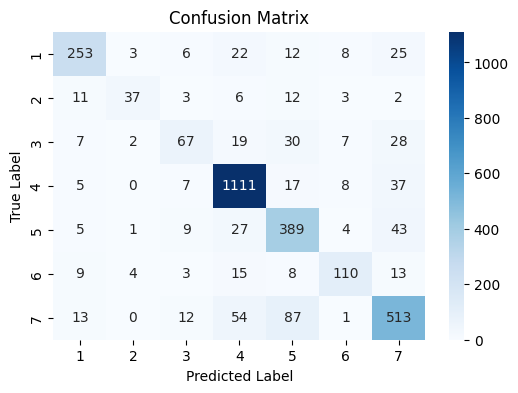

In [32]:
# Generate confusion matrix
cm = confusion_matrix(true_class_labels, predicted_labels)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

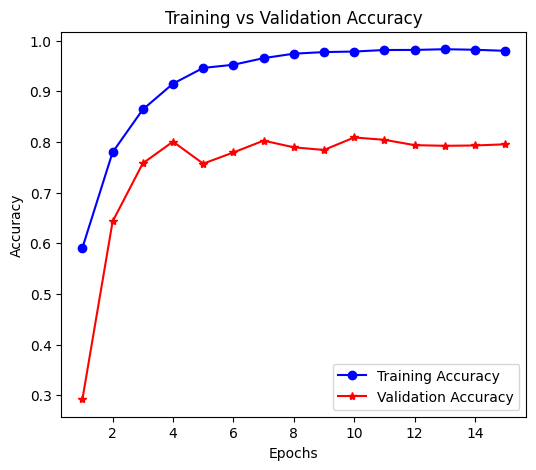

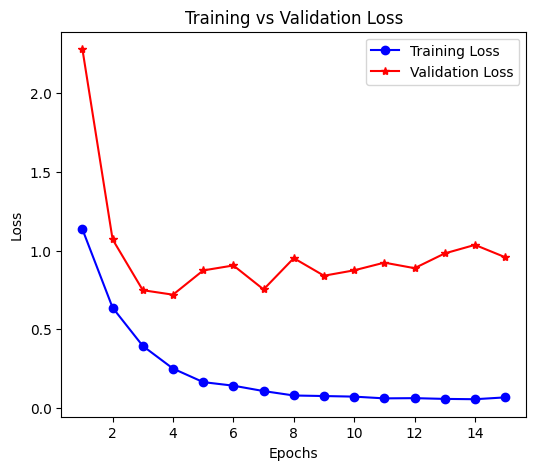

In [19]:
import matplotlib.pyplot as plt

# Define epochs based on history length
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Training vs Validation Loss
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()